# Predicting Human Age from Biomarkers: Traditional ML vs Deep Neural Networks

This notebook presents a research-oriented comparison between traditional machine learning (ML) models and deep neural networks (DNNs) for predicting human age using a wide range of biomarker data. The dataset, derived from the [Kaggle Precision Health Competition](https://www.kaggle.com/competitions/precision-health-predicting-human-age-with-biomark), consists of anonymized features such as physiological metrics, lifestyle indicators, and environmental factors.

### Objectives:

* Understand which biomarkers contribute significantly to age prediction.
* Evaluate classical regression models (Linear, Ridge, Random Forest, etc.).
* Experiment with multiple DNN architectures and training strategies.
* Compare traditional ML and DNNs on the same tabular dataset.
* Recommend the best model for accurate, generalizable age prediction.

## 1. Environment Setup and Library Imports

We begin by importing all essential Python libraries for data manipulation, visualization, preprocessing, modeling, evaluation, and deep learning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import keras
import joblib
import random 
import os

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

# Linear Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# Ensemble Methods
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

# Boosting Methods
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Support Vector Regression
from sklearn.svm import SVR

# Deep Neural Network
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.losses import MeanSquaredError

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

# Reproducibility setup
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    try:
        import tensorflow as tf
        tf.random.set_seed(seed)
    except ImportError:
        pass

set_seed(42)

2025-05-15 08:46:05.646467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747298765.864187      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747298765.925641      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 2. Load and Explore Dataset

We load the dataset and take an initial look at its structure, data types, and a few representative rows to understand the nature of the features involved in age prediction.


### Feature Dictionary

Each row in the dataset represents a unique individual and contains a mix of categorical and numerical biomarkers. Below is a summary of the most important features:

| Feature                                          | Description                          |
| ------------------------------------------------ | ------------------------------------ |
| `Gender`                                         | Biological sex of the individual.    |
| `Height`, `Weight`, `BMI`                        | Physical characteristics.            |
| `Cholesterol`, `Blood Glucose`, `Blood Pressure` | Key health indicators.               |
| `Diet`, `Smoking`, `Alcohol Consumption`         | Lifestyle behaviors.                 |
| `Chronic Diseases`, `Family History`             | Health history.                      |
| `Cognitive Function`, `Mental Health`, `Stress`  | Psychological and cognitive metrics. |
| `Pollution Exposure`, `Sun Exposure`             | Environmental factors.               |
| `Education Level`, `Income Level`                | Socioeconomic context.               |
| `Age (years)`                                    | Target variable to predict.          |

In [2]:
data = pd.read_csv("/kaggle/input/precision-health-predicting-human-age-with-biomark/Train.csv")
data

ID  Gender  Height (cm)  Weight (kg) Blood Pressure (s/d)  \
0        1    Male   171.148359    86.185197              151/109   
1        2    Male   172.946206    79.641937              134/112   
2        3  Female   155.945488    49.167058              160/101   
3        4  Female   169.078298    56.017921               133/94   
4        5  Female   163.758355    73.966304              170/106   
...    ...     ...          ...          ...                  ...   
2995  2996    Male   161.632502    88.323405               134/91   
2996  2997    Male   163.443512    93.217007               110/78   
2997  2998    Male   177.857644    86.258847              159/116   
2998  2999  Female   162.287164    41.371018               134/82   
2999  3000    Male   175.341710    78.718038               167/91   

      Cholesterol Level (mg/dL)        BMI  Blood Glucose Level (mg/dL)  \
0                    259.465814  29.423017                   157.652848   
1                    263.630292  26.626847                   118.507805   
2                    207.846206  20.217553                   143.587550   
3                    253.283779  19.595270                   137.448581   
4                    236.119899  27.582078                   145.328695   
...                         ...        ...                          ...   
2995                 204.175510  33.807917                   112.075747   
2996                 197.384424  34.894725                   101.177692   
2997                 238.641542  27.268332                   110.548146   
2998                 198.244328  15.708252                   123.704379   
2999                 279.118184  25.603762                   156.577316   

      Bone Density (g/cm²)  Vision Sharpness  ...  Family History  \
0                 0.132868          0.200000  ...             NaN   
1                 0.629534          0.267312  ...   Heart Disease   
2                 0.473487          0.248667  ...    Hypertension   
3                 1.184315          0.513818  ...    Hypertension   
4                 0.434562          0.306864  ...             NaN   
...                    ...               ...  ...             ...   
2995              1.583006          0.665907  ...        Diabetes   
2996              1.785129          0.720304  ...   Heart Disease   
2997              0.366012          0.200000  ...             NaN   
2998              1.452963          0.648158  ...    Hypertension   
2999              0.704319          0.578625  ...    Hypertension   

     Cognitive Function Mental Health Status Sleep Patterns Stress Levels  \
0             44.059172                 Good       Insomnia      2.797064   
1             45.312298                 Good         Normal      9.339930   
2             56.246991                 Poor       Insomnia      9.234637   
3             55.196092                 Poor       Insomnia      4.693446   
4             53.023379                 Good         Normal      4.038537   
...                 ...                  ...            ...           ...   
2995          57.820282                 Fair         Normal      8.091897   
2996          68.783715                 Good         Normal      2.427081   
2997          50.133807                 Fair         Normal      7.671837   
2998          68.864629                 Good       Insomnia      7.920076   
2999          60.892114                 Poor       Insomnia      8.013913   

     Pollution Exposure Sun Exposure Education Level  Income Level Age (years)  
0              5.142344     7.108975             NaN        Medium          89  
1              7.272720     3.918489   Undergraduate        Medium          77  
2              8.500386     5.393408             NaN        Medium          70  
3              7.555511     2.745578             NaN           Low          52  
4              9.429097     3.878435   Undergraduate          High          79  
...                 ...          ...  

In [3]:
data.columns

Index(['ID', 'Gender', 'Height (cm)', 'Weight (kg)', 'Blood Pressure (s/d)',
       'Cholesterol Level (mg/dL)', 'BMI', 'Blood Glucose Level (mg/dL)',
       'Bone Density (g/cm²)', 'Vision Sharpness', 'Hearing Ability (dB)',
       'Physical Activity Level', 'Smoking Status', 'Alcohol Consumption',
       'Diet', 'Chronic Diseases', 'Medication Use', 'Family History',
       'Cognitive Function', 'Mental Health Status', 'Sleep Patterns',
       'Stress Levels', 'Pollution Exposure', 'Sun Exposure',
       'Education Level', 'Income Level', 'Age (years)'],
      dtype='object')

In [4]:
data.describe()

ID  Height (cm)  Weight (kg)  Cholesterol Level (mg/dL)  \
count  3000.000000  3000.000000  3000.000000                3000.000000   
mean   1500.500000   168.590835    72.537260                 234.029794   
std     866.169729     9.293006    13.190734                  24.521436   
min       1.000000   141.130985    32.537672                 148.811514   
25%     750.750000   161.629515    63.222773                 216.756601   
50%    1500.500000   168.215632    71.448651                 234.376822   
75%    2250.250000   175.522665    81.702801                 250.646674   
max    3000.000000   198.112215   123.598603                 331.300589   

               BMI  Blood Glucose Level (mg/dL)  Bone Density (g/cm²)  \
count  3000.000000                  3000.000000           3000.000000   
mean     25.550146                   126.653909              0.931899   
std       4.367322                    18.226124              0.443550   
min      12.049900                    69.866884             -0.219787   
25%      22.454115                   114.392605              0.561063   
50%      25.352113                   126.802186              0.939585   
75%      28.403543                   139.377079              1.294570   
max      43.329869                   185.736144              1.999829   

       Vision Sharpness  Hearing Ability (dB)  Cognitive Function  \
count       3000.000000           3000.000000         3000.000000   
mean           0.474591             47.016214           63.868376   
std            0.209726             14.336464           11.755738   
min            0.200000              0.000000           30.382098   
25%            0.281671             36.734775           55.647794   
50%            0.462070             46.963733           64.014652   
75%            0.639498             56.828847           72.087453   
max            1.062537             94.003824          106.479831   

       Stress Levels  Pollution Exposure  Sun Exposure  Age (years)  
count    3000.000000         3000.000000   3000.000000  3000.000000  
mean        5.476507            5.028982      5.955785    53.485667  
std         2.584901            2.871408      3.474595    20.569690  
min         1.000428            0.006395      0.002055    18.000000  
25%         3.221745            2.607185      2.873285    36.000000  
50%         5.496618            5.095686      5.956789    53.000000  
75%         7.680320            7.476338      8.991349    72.000000  
max         9.996323            9.998090     11.992504    89.000000

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           3000 non-null   int64  
 1   Gender                       3000 non-null   object 
 2   Height (cm)                  3000 non-null   float64
 3   Weight (kg)                  3000 non-null   float64
 4   Blood Pressure (s/d)         3000 non-null   object 
 5   Cholesterol Level (mg/dL)    3000 non-null   float64
 6   BMI                          3000 non-null   float64
 7   Blood Glucose Level (mg/dL)  3000 non-null   float64
 8   Bone Density (g/cm²)         3000 non-null   float64
 9   Vision Sharpness             3000 non-null   float64
 10  Hearing Ability (dB)         3000 non-null   float64
 11  Physical Activity Level      3000 non-null   object 
 12  Smoking Status               3000 non-null   object 
 13  Alcohol Consumptio

## 3. Data Splitting

We split the dataset into training and validation sets to ensure that the evaluation of model performance is unbiased. The validation set simulates unseen data and helps assess the generalization ability of our models.

In [6]:
# Define X and y
X = data.drop(columns=['Age (years)', 'ID'])  
y = data['Age (years)']

# Splitting the Data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_Val: {X_val.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_val: {y_val.shape}")

Shape of X_train: (2400, 25)
Shape of X_Val: (600, 25)
Shape of y_train: (2400,)
Shape of y_val: (600,)


## 4. Data Cleaning and Missing Value Handling

We first identify and visualize missing values in the dataset. Categorical columns with missing data—like `Alcohol Consumption`, `Chronic Diseases`, and `Education Level`—are imputed using their most frequent (mode) values.

This imputation strategy is justified because:

* The missing percentage is relatively low (mostly under 50%).
* The distributions show clearly dominant classes.
* It maintains consistency with existing trends in the data.

In [7]:
# Count missing values
missing_counts = data.isna().sum()

# Calculate percentage of missing values
missing_percentages = (missing_counts * 100) / len(data)

# Display
print("Missing Values (Count):")
print(missing_counts[missing_counts > 0])

print("\nMissing Values (Percentage):")
print(missing_percentages[missing_percentages > 0].round(2))

Missing Values (Count):
Alcohol Consumption    1201
Chronic Diseases       1299
Medication Use         1198
Family History         1451
Education Level         627
dtype: int64

Missing Values (Percentage):
Alcohol Consumption    40.03
Chronic Diseases       43.30
Medication Use         39.93
Family History         48.37
Education Level        20.90
dtype: float64


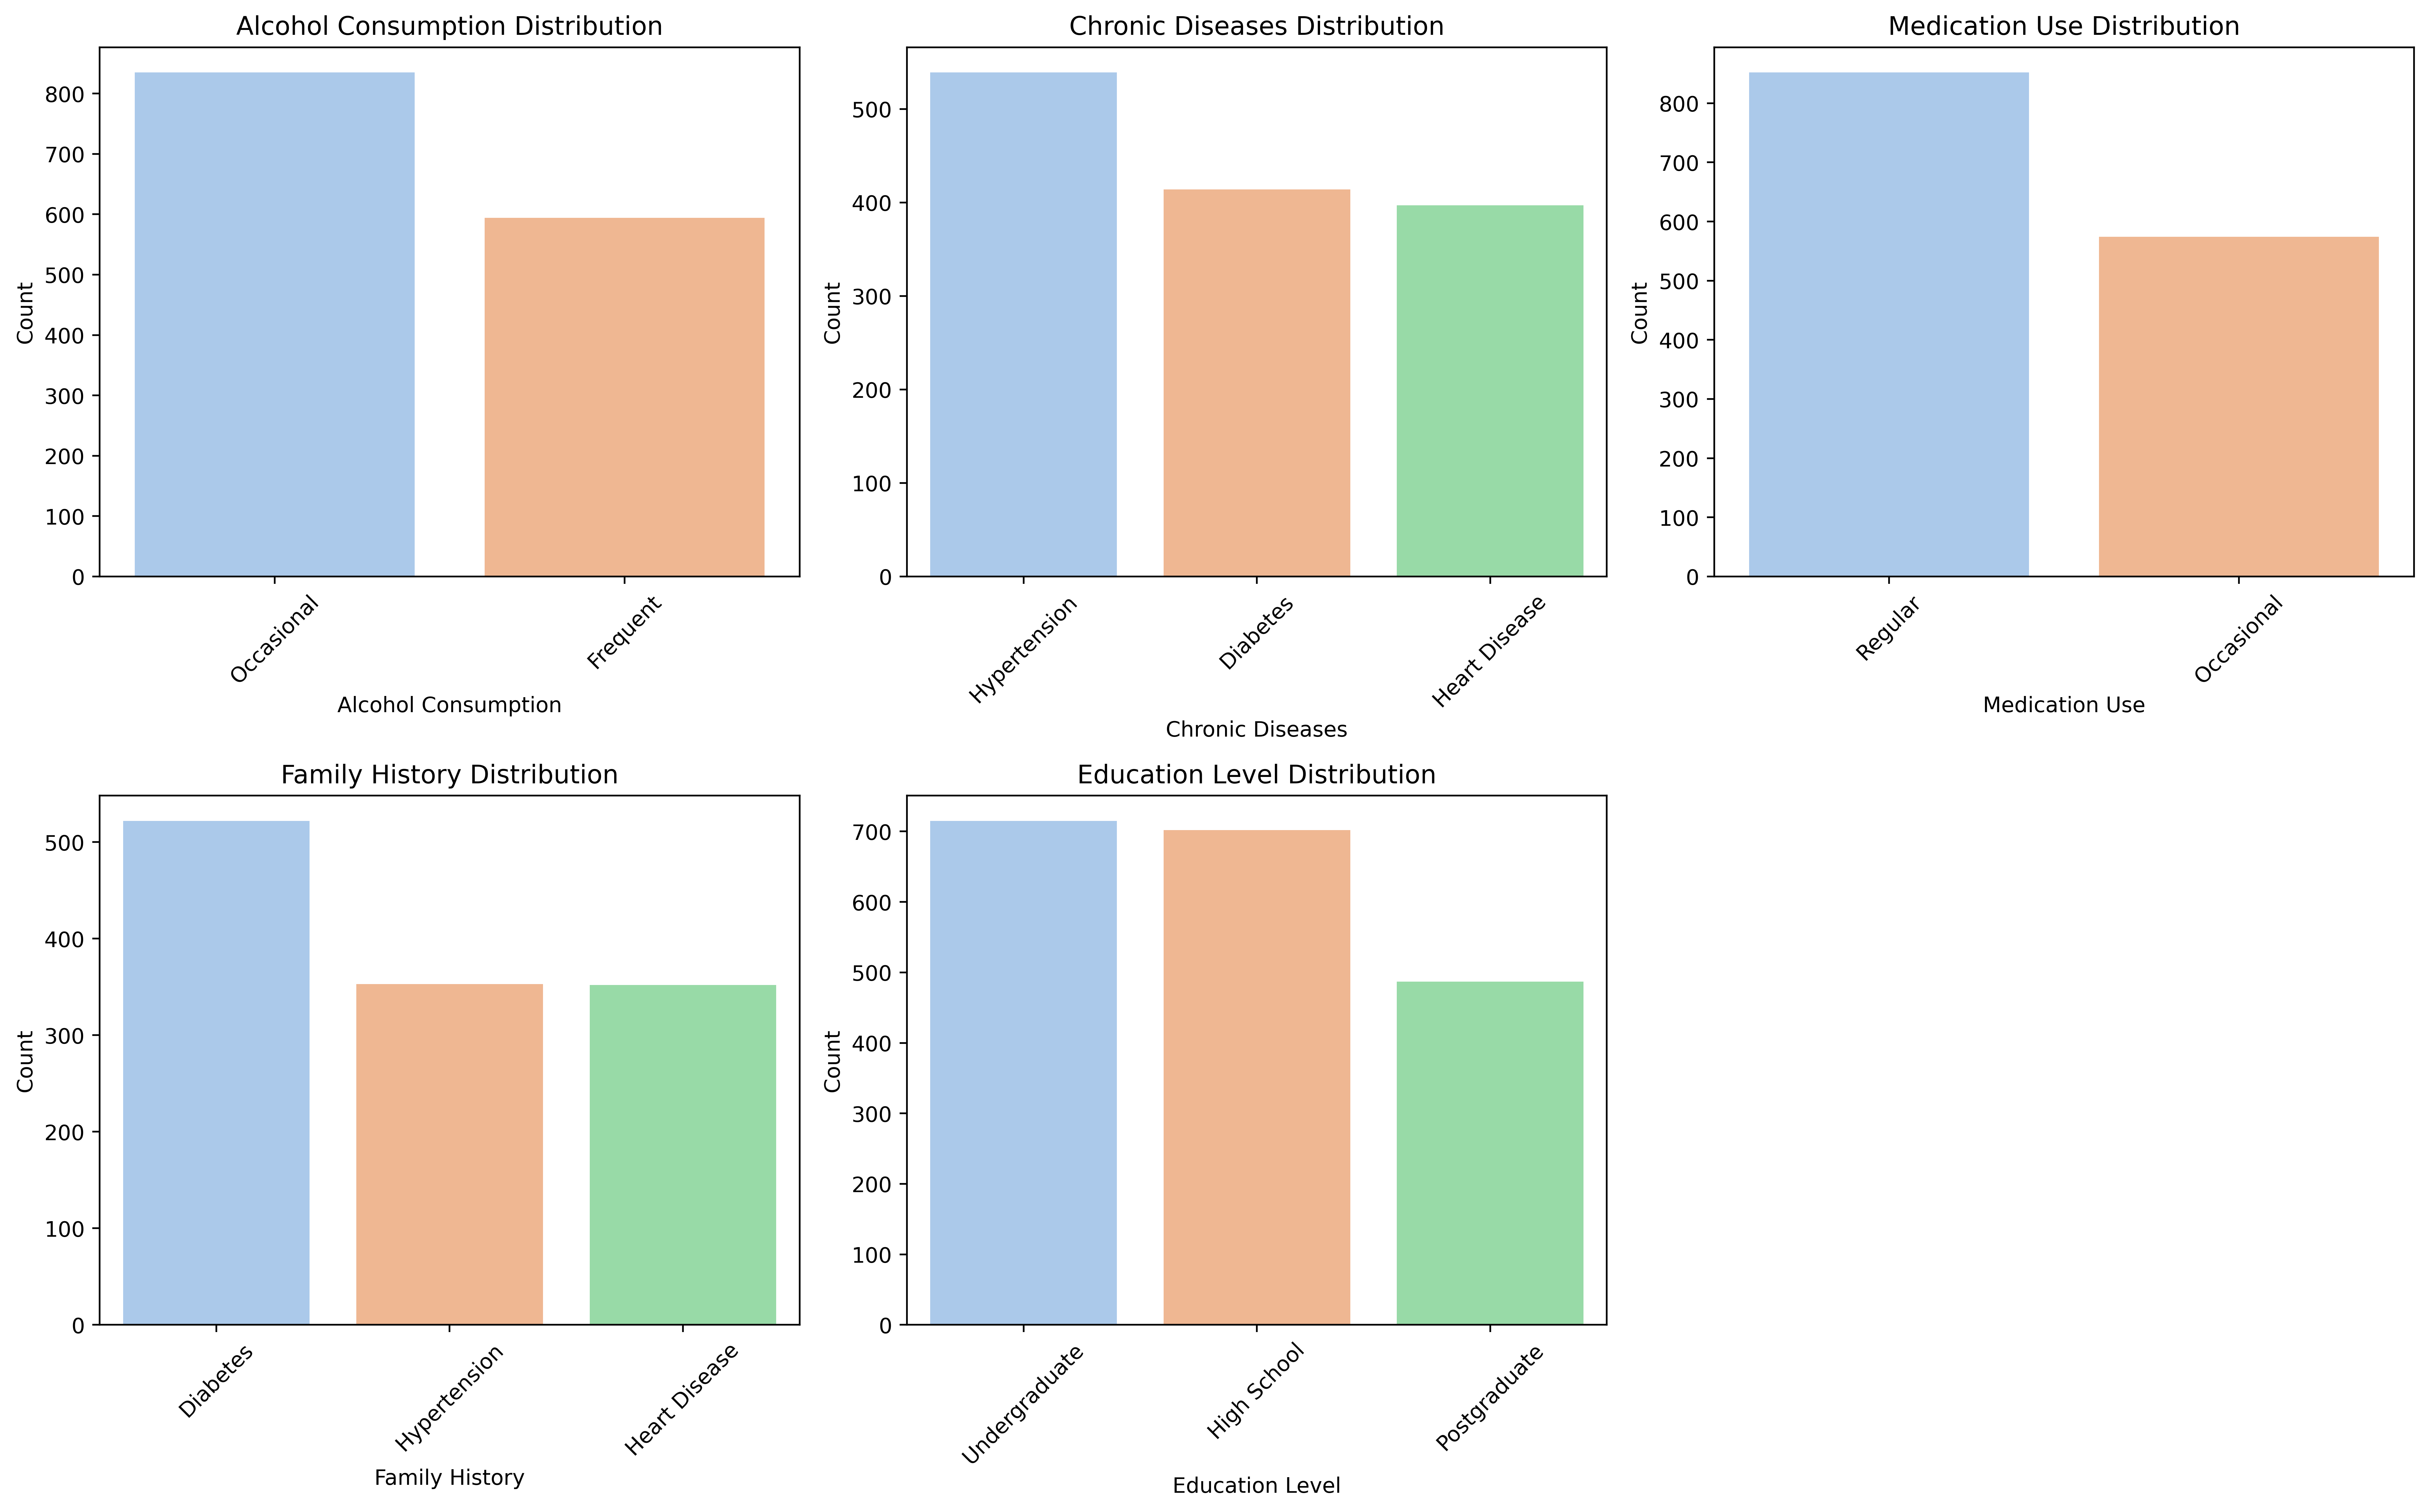

In [8]:
# Select columns with missing values
missing_columns = ['Alcohol Consumption', 'Chronic Diseases', 'Medication Use', 'Family History', 'Education Level']

# Set up the plotting grid
plt.figure(figsize=(16, 10), dpi=500)

# Plot distribution for each column
for i, col in enumerate(missing_columns, 1):
    plt.subplot(2, 3, i)
    sns.countplot(data=X_train, x=col, palette='pastel', order=X_train[col].value_counts().index)
    plt.title(f'{col} Distribution')
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [9]:
X_train['Alcohol Consumption'] = X_train['Alcohol Consumption'].fillna('Occasional')
X_train['Chronic Diseases'] = X_train['Chronic Diseases'].fillna('Hypertension')
X_train['Medication Use'] = X_train['Medication Use'].fillna('Regular')
X_train['Family History'] = X_train['Family History'].fillna('Diabetes')
X_train['Education Level'] = X_train['Education Level'].fillna('High School')

In [10]:
X_train.isna().sum()

Gender                         0
Height (cm)                    0
Weight (kg)                    0
Blood Pressure (s/d)           0
Cholesterol Level (mg/dL)      0
BMI                            0
Blood Glucose Level (mg/dL)    0
Bone Density (g/cm²)           0
Vision Sharpness               0
Hearing Ability (dB)           0
Physical Activity Level        0
Smoking Status                 0
Alcohol Consumption            0
Diet                           0
Chronic Diseases               0
Medication Use                 0
Family History                 0
Cognitive Function             0
Mental Health Status           0
Sleep Patterns                 0
Stress Levels                  0
Pollution Exposure             0
Sun Exposure                   0
Education Level                0
Income Level                   0
dtype: int64

## 5. Feature Engineering

To prepare the dataset for modeling:

* **Blood Pressure** is split into `Systolic BP` and `Diastolic BP` from the original `s/d` format.
* **Gender** is binary encoded (`Male` → 1, `Female` → 0).
* All features are cleaned and standardized for use in downstream ML pipelines.

These transformations ensure that all variables are numerically meaningful and model-ready.

In [11]:
# Splitting Blood Pressure into Systolic and Diastolic
X_train[['Systolic BP', 'Diastolic BP']] = X_train['Blood Pressure (s/d)'].str.split('/', expand=True).astype(float)
X_train.drop(columns='Blood Pressure (s/d)', inplace=True)
X_train

Gender  Height (cm)  Weight (kg)  Cholesterol Level (mg/dL)        BMI  \
642   Female   160.139450    71.297932                 289.101904  27.802271   
700   Female   169.074874    77.486558                 212.677674  27.106174   
226   Female   156.425167    78.787222                 208.855699  32.199011   
1697  Female   174.675118    74.798128                 218.936915  24.514816   
1010  Female   156.811770    47.198633                 178.086036  19.194292   
...      ...          ...          ...                        ...        ...   
1638  Female   153.714807    70.020055                 233.455401  29.634052   
1095    Male   188.299437    95.870407                 190.167087  27.038745   
1130  Female   168.226842    64.511606                 235.731597  22.795403   
1294    Male   150.826521    84.614715                 231.721782  37.195505   
860     Male   184.377972    91.808090                 227.095505  27.006163   

      Blood Glucose Level (mg/dL)  Bone Density (g/cm²)  Vision Sharpness  \
642                    151.556496              0.564728          0.282490   
700                    116.064765              0.974500          0.540907   
226                     82.767010              1.306898          0.808245   
1697                    95.126943              1.412120          0.712546   
1010                   125.632801              0.487750          0.200000   
...                           ...                   ...               ...   
1638                   124.833809              0.415526          0.474095   
1095                    88.791398              1.261835          0.751089   
1130                   119.872754              1.489085          0.607289   
1294                   126.323553              0.502641          0.200000   
860                    139.715774              0.365177          0.250847   

      Hearing Ability (dB) Physical Activity Level  ... Cognitive Function  \
642              55.486284                Moderate  ...          39.703142   
700              56.447475                     Low  ...          63.152441   
226              22.194428                Moderate  ...          69.452626   
1697             31.848349                Moderate  ...          69.376851   
1010             59.508659                    High  ...          55.266287   
...                    ...                     ...  ...                ...   
1638             51.565880                     Low  ...          54.816104   
1095             51.718170                Moderate  ...          68.507480   
1130             29.432371                Moderate  ...          66.033291   
1294             54.589067                     Low  ...          65.970086   
860              79.416980                    High  ...          75.430413   

     Mental Health Status Sleep Patterns Stress Levels Pollution Exposure  \
642                  Fair         Normal      9.609288           9.937148   
700                  Poor      Excessive      4.362499           9.828803   
226                  Fair       Insomnia      4.759377           0.730851   
1697                 Poor      Excessive      4.495804           6.294889   
1010            Excellent         Normal      3.460998           9.009351   
...                   ...            ...           ...                ...   
1638                 Fair         Normal      5.850972           1.518624   
1095                 Fair         Normal      7.758318           9.551052   
1130                 Poor         Normal      4.726212           9.194098   
1294                 Poor       Insomnia      9.374734           3.206524   
860                  Poor      Excessive      7.974916           9.407525   

     Sun Exposure  Education Level Income Level Systolic BP  Diastolic BP  
642     10.992007      High School       Medium       151.0          97.0  
700      0.430130    Undergraduate          Low       135.0          86.0  
226      3.283997     Postgrad

In [12]:
# Binary Encode Gender
X_train['Gender'] = X_train['Gender'].map({'Male': 1, 'Female': 0})

## 6. Outlier Detection and Removal

Outliers can severely affect certain models, especially those sensitive to data distributions (e.g., Ridge, SVR). We apply the **IQR method** only on the training data to avoid data leakage.

* **Boxplots** help visually identify extreme values in features like BMI, Glucose, and Bone Density.
* We remove rows that fall outside 1.5x IQR bounds for numeric columns.
* Post-cleaning, we preserve alignment between features and target labels (`y_train_clean`).

This step improves the reliability of models prone to overfitting or skewed learning.

In [13]:
numerical_cols = [
    'Height (cm)', 'Weight (kg)', 'Cholesterol Level (mg/dL)', 'BMI',
    'Blood Glucose Level (mg/dL)', 'Bone Density (g/cm²)', 'Vision Sharpness',
    'Hearing Ability (dB)', 'Cognitive Function', 'Stress Levels',
    'Pollution Exposure', 'Sun Exposure', 'Systolic BP', 'Diastolic BP'
]

sns.set(style="whitegrid", font_scale=1.1)
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 18), dpi=500)
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(y=X_train[col], ax=axes[i], color=sns.color_palette("pastel")[i % 10])
    axes[i].set_title(col, fontsize=10, weight='bold')
    axes[i].set_ylabel("")
    axes[i].grid(True, linestyle="--", linewidth=0.5)

# Remove extra empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Overall layout
fig.suptitle("Outlier Detection in Training Data (Boxplots)", fontsize=16, weight='bold', y=1.02)
plt.tight_layout()
plt.show()

The boxplots clearly visualize the distribution of each numerical feature in your training data and reveal the presence of outliers — data points that lie significantly beyond the interquartile range (IQR).

| Feature                             | Outliers Present? | Comments                                                                                                  |
| ----------------------------------- | ----------------- | --------------------------------------------------------------------------------------------------------- |
| **Weight (kg)**                     | ✅ Yes             | A few upper outliers around 100+ kg; may reflect real variation, but review if biologically implausible.  |
| **Cholesterol Level (mg/dL)**       | ✅ Yes             | High outliers above 300 mg/dL may skew models like Ridge or SVR.                                          |
| **BMI**                             | ✅ Yes             | Some extreme BMI values, possibly due to input errors or rare cases.                                      |
| **Blood Glucose Level**             | ✅ Yes             | A long tail above 160 and below 80, could be problematic.                                                 |
| **Bone Density (g/cm²)**            | ✅ Yes             | Some very low or high values may indicate measurement noise.                                              |
| **Hearing Ability (dB)**            | ✅ Yes             | Multiple outliers on the high end; consider normal aging patterns.                                        |
| **Cognitive Function**              | ✅ Yes             | Some high outliers; may reflect actual variation but should be reviewed.                                  |
| **Systolic / Diastolic BP**         | ✅ Yes             | Both show tails on high and low ends — common in real populations, but extreme values might be anomalies. |
| **Stress, Pollution, Sun Exposure** | ⚠️ Mild           | Few scattered outliers — not extreme but still detectable.                                                |
| **Vision Sharpness**                | 🟢 No             | Mostly clean distribution, few mild deviations.                                                           |
| **Height (cm)**                     | 🟢 No             | Clean and centered around 160–180 cm — well-distributed.                                                  |

What To Do Next:

1. **Remove outliers for sensitive models**: Ridge, SVR, Lasso, ElasticNet
2. **Keep outliers for robust models**: Random Forest, XGBoost, Gradient Boosting
3. **Use IQR thresholding on training data only**, and apply same thresholds to validation/test to avoid leakage


In [14]:
# Define leakage-free IQR-based outlier removal on training data

def get_iqr_bounds(series):
    """Calculate IQR bounds for a pandas Series."""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper

def filter_outliers_iqr(df, ref_df, cols):
    """Remove rows in df where values in cols are outliers based on reference df."""
    mask = pd.Series([True] * len(df), index=df.index)
    for col in cols:
        lower, upper = get_iqr_bounds(ref_df[col])
        mask &= df[col].between(lower, upper)
    return df[mask]

# Step 2: Filter training data only using bounds from training data
X_train_clean = filter_outliers_iqr(X_train, X_train, numerical_cols)
y_train_clean = y_train.loc[X_train_clean.index]

# Step 3: Report change in shape
X_train.shape, X_train_clean.shape

((2400, 26), (2335, 26))

* **Original training samples**: 2400
* **After removing outliers (IQR)**: **2335**
* 🔻 **Removed 65 rows** that had extreme values in one or more numerical features.

In [15]:
y_train_clean = y_train.loc[X_train_clean.index]
y_train_clean.shape

(2335,)

In [16]:
sns.set(style="whitegrid", font_scale=1.1)
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 18), dpi=500)
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(y=X_train_clean[col], ax=axes[i], color=sns.color_palette("pastel")[i % 10])
    axes[i].set_title(col, fontsize=10, weight='bold')
    axes[i].set_ylabel("")
    axes[i].grid(True, linestyle="--", linewidth=0.5)

# Remove extra empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Overall layout
fig.suptitle("Outlier Detection in Training Data (Boxplots) after Outlier Removal.", fontsize=16, weight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 7. Feature Scaling and Encoding

We use `ColumnTransformer` to apply:

* **StandardScaler** to numerical columns.
* **OneHotEncoder** to categorical columns.

Two separate pipelines are created:

* A **scaled version** for models that are sensitive to feature magnitudes (e.g., Linear, Ridge, SVR, DNN).
* An **unscaled version** for tree-based models that are scale-invariant (e.g., Random Forest, XGBoost).

This dual preprocessing ensures fairness and optimization for each type of model.

### Summary: **Which Models Need Scaling?**

| **Model**                     | **Needs Scaling?** | **Why**                                                                                   |
| ----------------------------- | ------------------------ | ----------------------------------------------------------------------------------------- |
| **Linear Regression**         | ✅ Yes                    | Sensitive to feature scale; affects coefficients.                                         |
| **Ridge Regression**          | ✅ Yes                    | Regularization strength is scale-dependent.                                               |
| **Lasso Regression**          | ✅ Yes                    | Same reason as Ridge — regularization.                                                    |
| **Elastic Net**               | ✅ Yes                    | Combines Lasso and Ridge, also sensitive.                                                 |
| **Support Vector Regression** | ✅ Yes                    | Distance-based algorithm; kernel functions are scale-sensitive.                           |
| **K-Nearest Neighbors**       | ✅ Yes                    | Distance-based model; scaling is essential. *(if used)*                                   |
| **DNN (Deep Neural Network)** | ✅ Yes                    | Helps gradient descent converge efficiently; prevents dominance by large-valued features. |
| **Decision Tree**             | ❌ No                     | Tree splits are based on thresholds — scale doesn't matter.                               |
| **Random Forest**             | ❌ No                     | An ensemble of decision trees — not sensitive to scaling.                                 |
| **Gradient Boosting**         | ❌ No                     | Also tree-based — scaling has no effect.                                                  |
| **XGBoost**                   | ❌ No                     | Internally handles feature splits regardless of scale.                                    |
| **LightGBM**                  | ❌ No                     | Like XGBoost — scale-invariant.                                                           |
| **CatBoost**                  | ❌ No                     | Auto-handles categorical and numeric features.                                            |
| **AdaBoost**                  | ❌ No (Usually)           | Depends on the base estimator — if using trees, no scaling needed.                        |


### Best Practices

* **Always scale** when using: `Linear`, `Ridge`, `Lasso`, `ElasticNet`, `SVR`, `KNN`, `DNN`.
* **Do NOT scale** for: `Tree-based models` like `Decision Tree`, `RF`, `XGBoost`, `LightGBM`, `CatBoost`.


In [17]:
numerical_cols = ['Height (cm)', 'Weight (kg)', 'Cholesterol Level (mg/dL)', 'BMI',
                  'Blood Glucose Level (mg/dL)', 'Bone Density (g/cm²)', 'Vision Sharpness',
                  'Hearing Ability (dB)', 'Cognitive Function', 'Stress Levels',
                  'Pollution Exposure', 'Sun Exposure', 'Systolic BP', 'Diastolic BP']

categorical_cols = ['Smoking Status', 'Alcohol Consumption', 'Diet', 'Chronic Diseases',
                    'Medication Use', 'Family History', 'Mental Health Status',
                    'Sleep Patterns', 'Education Level', 'Income Level', 'Physical Activity Level']

# Create ColumnTransformer with scaling and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_cols)
    ],
    remainder='passthrough'  # This will include Gender
)

# Fit and transform
X_preprocessed = preprocessor.fit_transform(X_train_clean)

# Get column names
scaled_features = numerical_cols
encoded_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
remainder_features = ['Gender']
all_feature_names = list(scaled_features) + list(encoded_features) + remainder_features

# Create final DataFrame
X_scaled_data = pd.DataFrame(X_preprocessed, columns=all_feature_names)

# For unscaled version, replace scaler with 'passthrough'
unscaled_preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_cols)
    ],
    remainder='passthrough'
)

X_unscaled = unscaled_preprocessor.fit_transform(X_train_clean)
unscaled_feature_names = list(numerical_cols) + list(
    unscaled_preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
) + remainder_features

X_unscaled_data = pd.DataFrame(X_unscaled, columns=unscaled_feature_names)

In [18]:
X_scaled_data

Height (cm)  Weight (kg)  Cholesterol Level (mg/dL)       BMI  \
0       -0.899174    -0.080924                   2.282197  0.538814   
1        0.071732     0.405854                  -0.894413  0.373600   
2       -1.302761     0.508160                  -1.053275  1.582348   
3        0.680244     0.194391                  -0.634244 -0.241440   
4       -1.260754    -1.976498                  -2.332231 -1.504228   
...           ...          ...                        ...       ...   
2330    -1.597264    -0.181438                  -0.030776  0.973573   
2331     2.160636     1.851869                  -1.830076  0.357596   
2332    -0.020414    -0.614715                   0.063835 -0.649530   
2333    -1.911099     0.966532                  -0.102835  2.768229   
2334     1.734538     1.532340                  -0.295129  0.349863   

      Blood Glucose Level (mg/dL)  Bone Density (g/cm²)  Vision Sharpness  \
0                        1.377306             -0.822190         -0.912927   
1                       -0.570672              0.103906          0.324923   
2                       -2.398233              0.855132          1.605505   
3                       -1.719853              1.092936          1.147092   
4                       -0.045527             -0.996161         -1.308064   
...                           ...                   ...               ...   
2330                    -0.089380             -1.159389          0.004887   
2331                    -2.067582              0.753290          1.331717   
2332                    -0.361669              1.266880          0.642902   
2333                    -0.007614             -0.962508         -1.308064   
2334                     0.727423             -1.273180         -1.064501   

      Hearing Ability (dB)  Cognitive Function  Stress Levels  ...  \
0                 0.585966           -2.071416       1.583194  ...   
1                 0.653455           -0.045423      -0.443602  ...   
2                -1.751567            0.498906      -0.290291  ...   
3                -1.073733            0.492359      -0.392107  ...   
4                 0.868391           -0.726778      -0.791845  ...   
...                    ...                 ...            ...  ...   
2330              0.310702           -0.765673       0.131384  ...   
2331              0.321394            0.417246       0.868178  ...   
2332             -1.243367            0.203479      -0.303102  ...   
2333              0.522970            0.198018       1.492587  ...   
2334              2.266221            1.015380       0.951848  ...   

      Education Level_High School  Education Level_Postgraduate  \
0                             1.0                           0.0   
1                             0.0                           0.0   
2                             0.0                           1.0   
3                             0.0                           1.0   
4                             1.0                           0.0   
...                           ...                           ...   
2330                          0.0                           1.0   
2331                          1.0                           0.0   
2332                          0.0                           1.0   
2333                          1.0                           0.0   
2334                          0.0                           1.0   

      Education Level_Undergraduate  Income Level_High  Income Level_Low  \
0                               0.0                0.0               0.0   
1                               1.0                0.0               1.0   
2                               0.0                0.0               0.0   
3                               0.0                1.0               0.0   
4                               0.0                0.0               0.0   
...                             ...                ...               ...   
2330                            0.0               

In [19]:
X_unscaled_data

Height (cm)  Weight (kg)  Cholesterol Level (mg/dL)        BMI  \
0      160.139450    71.297932                 289.101904  27.802271   
1      169.074874    77.486558                 212.677674  27.106174   
2      156.425167    78.787222                 208.855699  32.199011   
3      174.675118    74.798128                 218.936915  24.514816   
4      156.811770    47.198633                 178.086036  19.194292   
...           ...          ...                        ...        ...   
2330   153.714807    70.020055                 233.455401  29.634052   
2331   188.299437    95.870407                 190.167087  27.038745   
2332   168.226842    64.511606                 235.731597  22.795403   
2333   150.826521    84.614715                 231.721782  37.195505   
2334   184.377972    91.808090                 227.095505  27.006163   

      Blood Glucose Level (mg/dL)  Bone Density (g/cm²)  Vision Sharpness  \
0                      151.556496              0.564728          0.282490   
1                      116.064765              0.974500          0.540907   
2                       82.767010              1.306898          0.808245   
3                       95.126943              1.412120          0.712546   
4                      125.632801              0.487750          0.200000   
...                           ...                   ...               ...   
2330                   124.833809              0.415526          0.474095   
2331                    88.791398              1.261835          0.751089   
2332                   119.872754              1.489085          0.607289   
2333                   126.323553              0.502641          0.200000   
2334                   139.715774              0.365177          0.250847   

      Hearing Ability (dB)  Cognitive Function  Stress Levels  ...  \
0                55.486284           39.703142       9.609288  ...   
1                56.447475           63.152441       4.362499  ...   
2                22.194428           69.452626       4.759377  ...   
3                31.848349           69.376851       4.495804  ...   
4                59.508659           55.266287       3.460998  ...   
...                    ...                 ...            ...  ...   
2330             51.565880           54.816104       5.850972  ...   
2331             51.718170           68.507480       7.758318  ...   
2332             29.432371           66.033291       4.726212  ...   
2333             54.589067           65.970086       9.374734  ...   
2334             79.416980           75.430413       7.974916  ...   

      Education Level_High School  Education Level_Postgraduate  \
0                             1.0                           0.0   
1                             0.0                           0.0   
2                             0.0                           1.0   
3                             0.0                           1.0   
4                             1.0                           0.0   
...                           ...                           ...   
2330                          0.0                           1.0   
2331                          1.0                           0.0   
2332                          0.0                           1.0   
2333                          1.0                           0.0   
2334                          0.0                           1.0   

      Education Level_Undergraduate  Income Level_High  Income Level_Low  \
0                               0.0                0.0               0.0   
1                               1.0                0.0               1.0   
2                               0.0                0.0               0.0   
3                               0.0                1.0               0.0   
4                               0.0                0.0               0.0   
...                             ...                ...               ...   
2330                            0.0   

In [20]:
# Save both preprocessors
joblib.dump(preprocessor, 'preprocessor_scaled.pkl')

['preprocessor_scaled.pkl']

In [21]:
joblib.dump(unscaled_preprocessor, 'preprocessor_unscaled.pkl')

['preprocessor_unscaled.pkl']

**Both preprocessors fitted and saved:** *'preprocessor_scaled.pkl'* and *'preprocessor_unscaled.pkl'*.

## 8. Preprocessing for Seen and Unseen Data

Reusable preprocessing functions are defined:

* `preprocess_input_dataframe()` handles raw cleaning and transformation logic.
* `preprocess_and_transform_scaled()` and `preprocess_and_transform_unscaled()` apply saved preprocessing pipelines.

These functions enable seamless transformations for:

* Validation data (used during model evaluation),
* Real-world test data (for deployment),
* User inputs (for future UI integration).

In [22]:
# Preprocessing function to clean raw data
def preprocess_input_dataframe(df):
    df = df.copy()

    # Fill missing categorical values
    df['Alcohol Consumption'] = df['Alcohol Consumption'].fillna('Occasional')
    df['Chronic Diseases'] = df['Chronic Diseases'].fillna('Hypertension')
    df['Medication Use'] = df['Medication Use'].fillna('Regular')
    df['Family History'] = df['Family History'].fillna('Diabetes')
    df['Education Level'] = df['Education Level'].fillna('High School')

    # Encode gender
    df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})

    # Split Blood Pressure
    if 'Blood Pressure (s/d)' in df.columns:
        df[['Systolic BP', 'Diastolic BP']] = df['Blood Pressure (s/d)'].str.split('/', expand=True).astype(float)
        df.drop(columns='Blood Pressure (s/d)', inplace=True)

    # Drop ID if present
    if 'ID' in df.columns:
        df.drop(columns='ID', inplace=True)

    return df

def transform_with_preprocessor(df, preprocessor_path):
    import joblib
    import pandas as pd

    # Load preprocessor
    preprocessor = joblib.load(preprocessor_path)

    # Transform input
    transformed_array = preprocessor.transform(df)

    # Attempt to retrieve feature names
    try:
        num_features = preprocessor.transformers_[0][2]  # numerical_cols
        cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(preprocessor.transformers_[1][2])  # get_feature_names_out(categorical_cols)
        passthrough_features = ['Gender']  # remainder='passthrough'
        all_feature_names = list(num_features) + list(cat_features) + passthrough_features
    except Exception as e:
        all_feature_names = [f"feature_{i}" for i in range(transformed_array.shape[1])]

    # Return as DataFrame
    return pd.DataFrame(transformed_array, columns=all_feature_names, index=df.index)


def preprocess_and_transform_scaled(df):
    """
    Preprocess and transform input data using the scaled pipeline.
    Used for models that require normalized features.
    """
    df_clean = preprocess_input_dataframe(df)
    return transform_with_preprocessor(df_clean, "preprocessor_scaled.pkl")

def preprocess_and_transform_unscaled(df):
    """
    Preprocess and transform input data using the unscaled pipeline.
    Used for tree-based models that do NOT need feature scaling.
    """
    df_clean = preprocess_input_dataframe(df)
    return transform_with_preprocessor(df_clean, "preprocessor_unscaled.pkl")

## 9. Validation Dataset Preparation

We preprocess the validation set with the **same pipeline** as the training data. This ensures the input distributions remain consistent and helps simulate real-world model inference behavior.

We then confirm:

* Matching shapes of train/validation sets.
* Identical feature columns after encoding and scaling.

In [23]:
# For Validation

# For SVR, Linear, Ridge, etc.
X_val_scaled = preprocess_and_transform_scaled(X_val)

# For Random Forest, XGBoost, etc.
X_val_unscaled = preprocess_and_transform_unscaled(X_val)

In [24]:
X_val_scaled

Height (cm)  Weight (kg)  Cholesterol Level (mg/dL)       BMI  \
1801    -0.422168    -2.277986                   1.430131 -2.257654   
1190    -0.832627    -1.278951                  -0.458674 -0.910294   
1817     1.066318    -1.322893                   0.028417 -1.912413   
251     -0.589041     1.472950                   0.340316  2.074610   
2505    -1.409962    -0.703694                   0.300388  0.166203   
...           ...          ...                        ...       ...   
104      0.096655     0.069124                  -0.096462  0.001705   
2087     1.028241     0.520886                  -1.246099 -0.137707   
599      0.321838     1.131889                  -1.208694  0.947868   
1756     0.608803    -0.311080                  -0.420506 -0.701063   
1323    -0.885448     0.062881                   1.516565  0.697355   

      Blood Glucose Level (mg/dL)  Bone Density (g/cm²)  Vision Sharpness  \
1801                     0.155181             -0.559692         -0.550769   
1190                    -0.258557             -0.231639          0.136557   
1817                    -1.313837             -0.045381          0.513407   
251                     -0.879403             -0.581252         -0.182929   
2505                     0.120684              0.368426         -0.212132   
...                           ...                   ...               ...   
104                     -0.094998             -1.587252         -1.308064   
2087                     0.686264              0.914364          2.039442   
599                     -0.472590              0.965251          1.173217   
1756                    -0.088540             -0.558898         -0.877836   
1323                     1.312476             -1.190993         -1.249510   

      Hearing Ability (dB)  Cognitive Function  Stress Levels  ...  \
1801              1.916246           -1.397336       1.071015  ...   
1190             -0.729110            0.542837      -0.819528  ...   
1817             -1.871184           -0.147422       1.307624  ...   
251               0.425989            0.343261       0.964104  ...   
2505             -0.525124           -1.928355       1.015411  ...   
...                    ...                 ...            ...  ...   
104               1.608790           -1.467868       0.442324  ...   
2087             -0.196892            1.071168       0.956785  ...   
599              -0.802240           -0.167244       1.231220  ...   
1756              1.304278           -0.142648      -0.024418  ...   
1323              0.469950           -0.496369      -0.255678  ...   

      Education Level_High School  Education Level_Postgraduate  \
1801                          1.0                           0.0   
1190                          0.0                           0.0   
1817                          1.0                           0.0   
251                           1.0                           0.0   
2505                          1.0                           0.0   
...                           ...                           ...   
104                           0.0                           1.0   
2087                          1.0                           0.0   
599                           0.0                           1.0   
1756                          0.0                           1.0   
1323                          0.0                           1.0   

      Education Level_Undergraduate  Income Level_High  Income Level_Low  \
1801                            0.0                0.0               0.0   
1190                            1.0                0.0               1.0   
1817                            0.0                0.0               0.0   
251                             0.0                0.0               0.0   
2505                            0.0                0.0               1.0   
...                             ...                ...               ...   
104                             0.0               

In [25]:
X_val_unscaled

Height (cm)  Weight (kg)  Cholesterol Level (mg/dL)        BMI  \
1801   164.529428    43.365677                 268.602544  16.019869   
1190   160.751894    56.066868                 223.160865  21.696720   
1817   178.228229    55.508211                 234.879510  17.474479   
251    162.993658    91.053031                 242.383303  34.273069   
2505   155.438579    63.380369                 241.422707  26.232346   
...           ...          ...                        ...        ...   
104    169.304241    73.205554                 231.875105  25.539263   
2087   177.877803    78.949009                 204.216643  24.951874   
599    171.376641    86.716976                 205.116567  29.525746   
1756   174.017631    68.371854                 224.079123  22.578280   
1323   160.265777    73.126191                 270.681990  28.470256   

      Blood Glucose Level (mg/dL)  Bone Density (g/cm²)  Vision Sharpness  \
1801                   129.289645              0.680876          0.358095   
1190                   121.751426              0.826031          0.501583   
1817                   102.524475              0.908445          0.580256   
251                    110.439768              0.671336          0.434886   
2505                   128.661118              1.091543          0.428790   
...                           ...                   ...               ...   
104                    124.731446              0.226209          0.200000   
2087                   138.965859              1.333106          0.898835   
599                    117.851796              1.355623          0.718000   
1756                   124.849106              0.681227          0.289816   
1323                   150.375311              0.401542          0.212224   

      Hearing Ability (dB)  Cognitive Function  Stress Levels  ...  \
1801             74.432533           47.505094       8.283404  ...   
1190             36.756572           69.961096       3.389336  ...   
1817             20.490809           61.971876       8.895916  ...   
251              53.207836           67.651151       8.006643  ...   
2505             39.661804           41.358955       8.139463  ...   
...                    ...                 ...            ...  ...   
104              70.053652           46.688739       6.655906  ...   
2087             44.336574           76.076120       7.987697  ...   
599              35.715030           61.742456       8.698129  ...   
1756             65.716694           62.027138       5.447646  ...   
1323             53.833939           57.933087       4.848982  ...   

      Education Level_High School  Education Level_Postgraduate  \
1801                          1.0                           0.0   
1190                          0.0                           0.0   
1817                          1.0                           0.0   
251                           1.0                           0.0   
2505                          1.0                           0.0   
...                           ...                           ...   
104                           0.0                           1.0   
2087                          1.0                           0.0   
599                           0.0                           1.0   
1756                          0.0                           1.0   
1323                          0.0                           1.0   

      Education Level_Undergraduate  Income Level_High  Income Level_Low  \
1801                            0.0                0.0               0.0   
1190                            1.0                0.0               1.0   
1817                            0.0                0.0               0.0   
251                             0.0                0.0               0.0   
2505                            0.0                0.0               1.0   
...                             ...                ...               ...   
104                             0.0   

In [26]:
# Confirm shapes and column name matches
{
    "X_val_scaled_shape": X_val_scaled.shape,
    "X_val_unscaled_shape": X_val_unscaled.shape,
    "X_train_scaled_shape": X_scaled_data.shape,
    "X_train_unscaled_shape": X_unscaled_data.shape,
    "scaled_columns_match": list(X_scaled_data.columns) == list(X_val_scaled.columns),
    "unscaled_columns_match": list(X_unscaled_data.columns) == list(X_val_unscaled.columns)
}


{'X_val_scaled_shape': (600, 48),
 'X_val_unscaled_shape': (600, 48),
 'X_train_scaled_shape': (2335, 48),
 'X_train_unscaled_shape': (2335, 48),
 'scaled_columns_match': True,
 'unscaled_columns_match': True}

## 10. Traditional Machine Learning Models

We evaluate a range of traditional regression models:

**With Scaling:**

* Linear Regression
* Ridge
* Lasso
* Elastic Net
* Support Vector Regression

**Without Scaling:**

* Decision Tree
* Random Forest
* Gradient Boosting
* XGBoost
* LightGBM
* CatBoost
* AdaBoost

Each model is trained on the training set and evaluated on the validation set using:

* **MAE** (Mean Absolute Error)
* **RMSE** (Root Mean Squared Error)
* **R² Score** (Explained Variance)

Performance results are compared in tabular and visual form.

In [27]:
# Define models that need scaling
scaled_models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Elastic Net": ElasticNet(),
    "Support Vector Regression": SVR()
}

# Define models that don't need scaling
unscaled_models = {
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor(),
    "CatBoost": CatBoostRegressor(verbose=0),
    "AdaBoost": AdaBoostRegressor()
}

In [28]:
# Evaluate models
results = []

for name, model in scaled_models.items():
    model.fit(X_scaled_data, y_train_clean)
    y_pred = model.predict(X_val_scaled)
    results.append({
        'Model': name,
        'MAE': mean_absolute_error(y_val, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_val, y_pred)),
        'R² Score': r2_score(y_val, y_pred)
    })

for name, model in unscaled_models.items():
    model.fit(X_unscaled_data, y_train_clean)
    y_pred = model.predict(X_val_unscaled)
    results.append({
        'Model': name,
        'MAE': mean_absolute_error(y_val, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_val, y_pred)),
        'R² Score': r2_score(y_val, y_pred)
    })

# Convert to DataFrame
results_df = pd.DataFrame(results).sort_values(by='RMSE')
results_df

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3262
[LightGBM] [Info] Number of data points in the train set: 2335, number of used features: 48
[LightGBM] [Info] Start training from score 53.679229


Model       MAE      RMSE  R² Score
1            Ridge Regression  4.233797  5.329339  0.930693
0           Linear Regression  4.234873  5.330433  0.930664
10                   CatBoost  4.290124  5.428117  0.928100
7           Gradient Boosting  4.341867  5.430398  0.928039
9                    LightGBM  4.440869  5.583296  0.923930
2            Lasso Regression  4.498459  5.624885  0.922792
6               Random Forest  4.503917  5.671277  0.921514
8                     XGBoost  4.790990  5.945587  0.913737
11                   AdaBoost  5.011425  6.160507  0.907388
3                 Elastic Net  5.067152  6.200950  0.906168
4   Support Vector Regression  5.112162  6.335336  0.902057
5               Decision Tree  6.108333  7.701623  0.855257

## 11. Model Performance Insights

From the evaluation:

* **Ridge Regression** emerged as the best performing model overall.
* Models like **CatBoost**, **Gradient Boosting**, and **Linear Regression** also performed competitively.
* **Decision Tree** and **Elastic Net** underperformed, likely due to overfitting or weak regularization.

Insights are visualized using well-styled bar plots for MAE, RMSE, and R² Score, offering a quick visual summary.

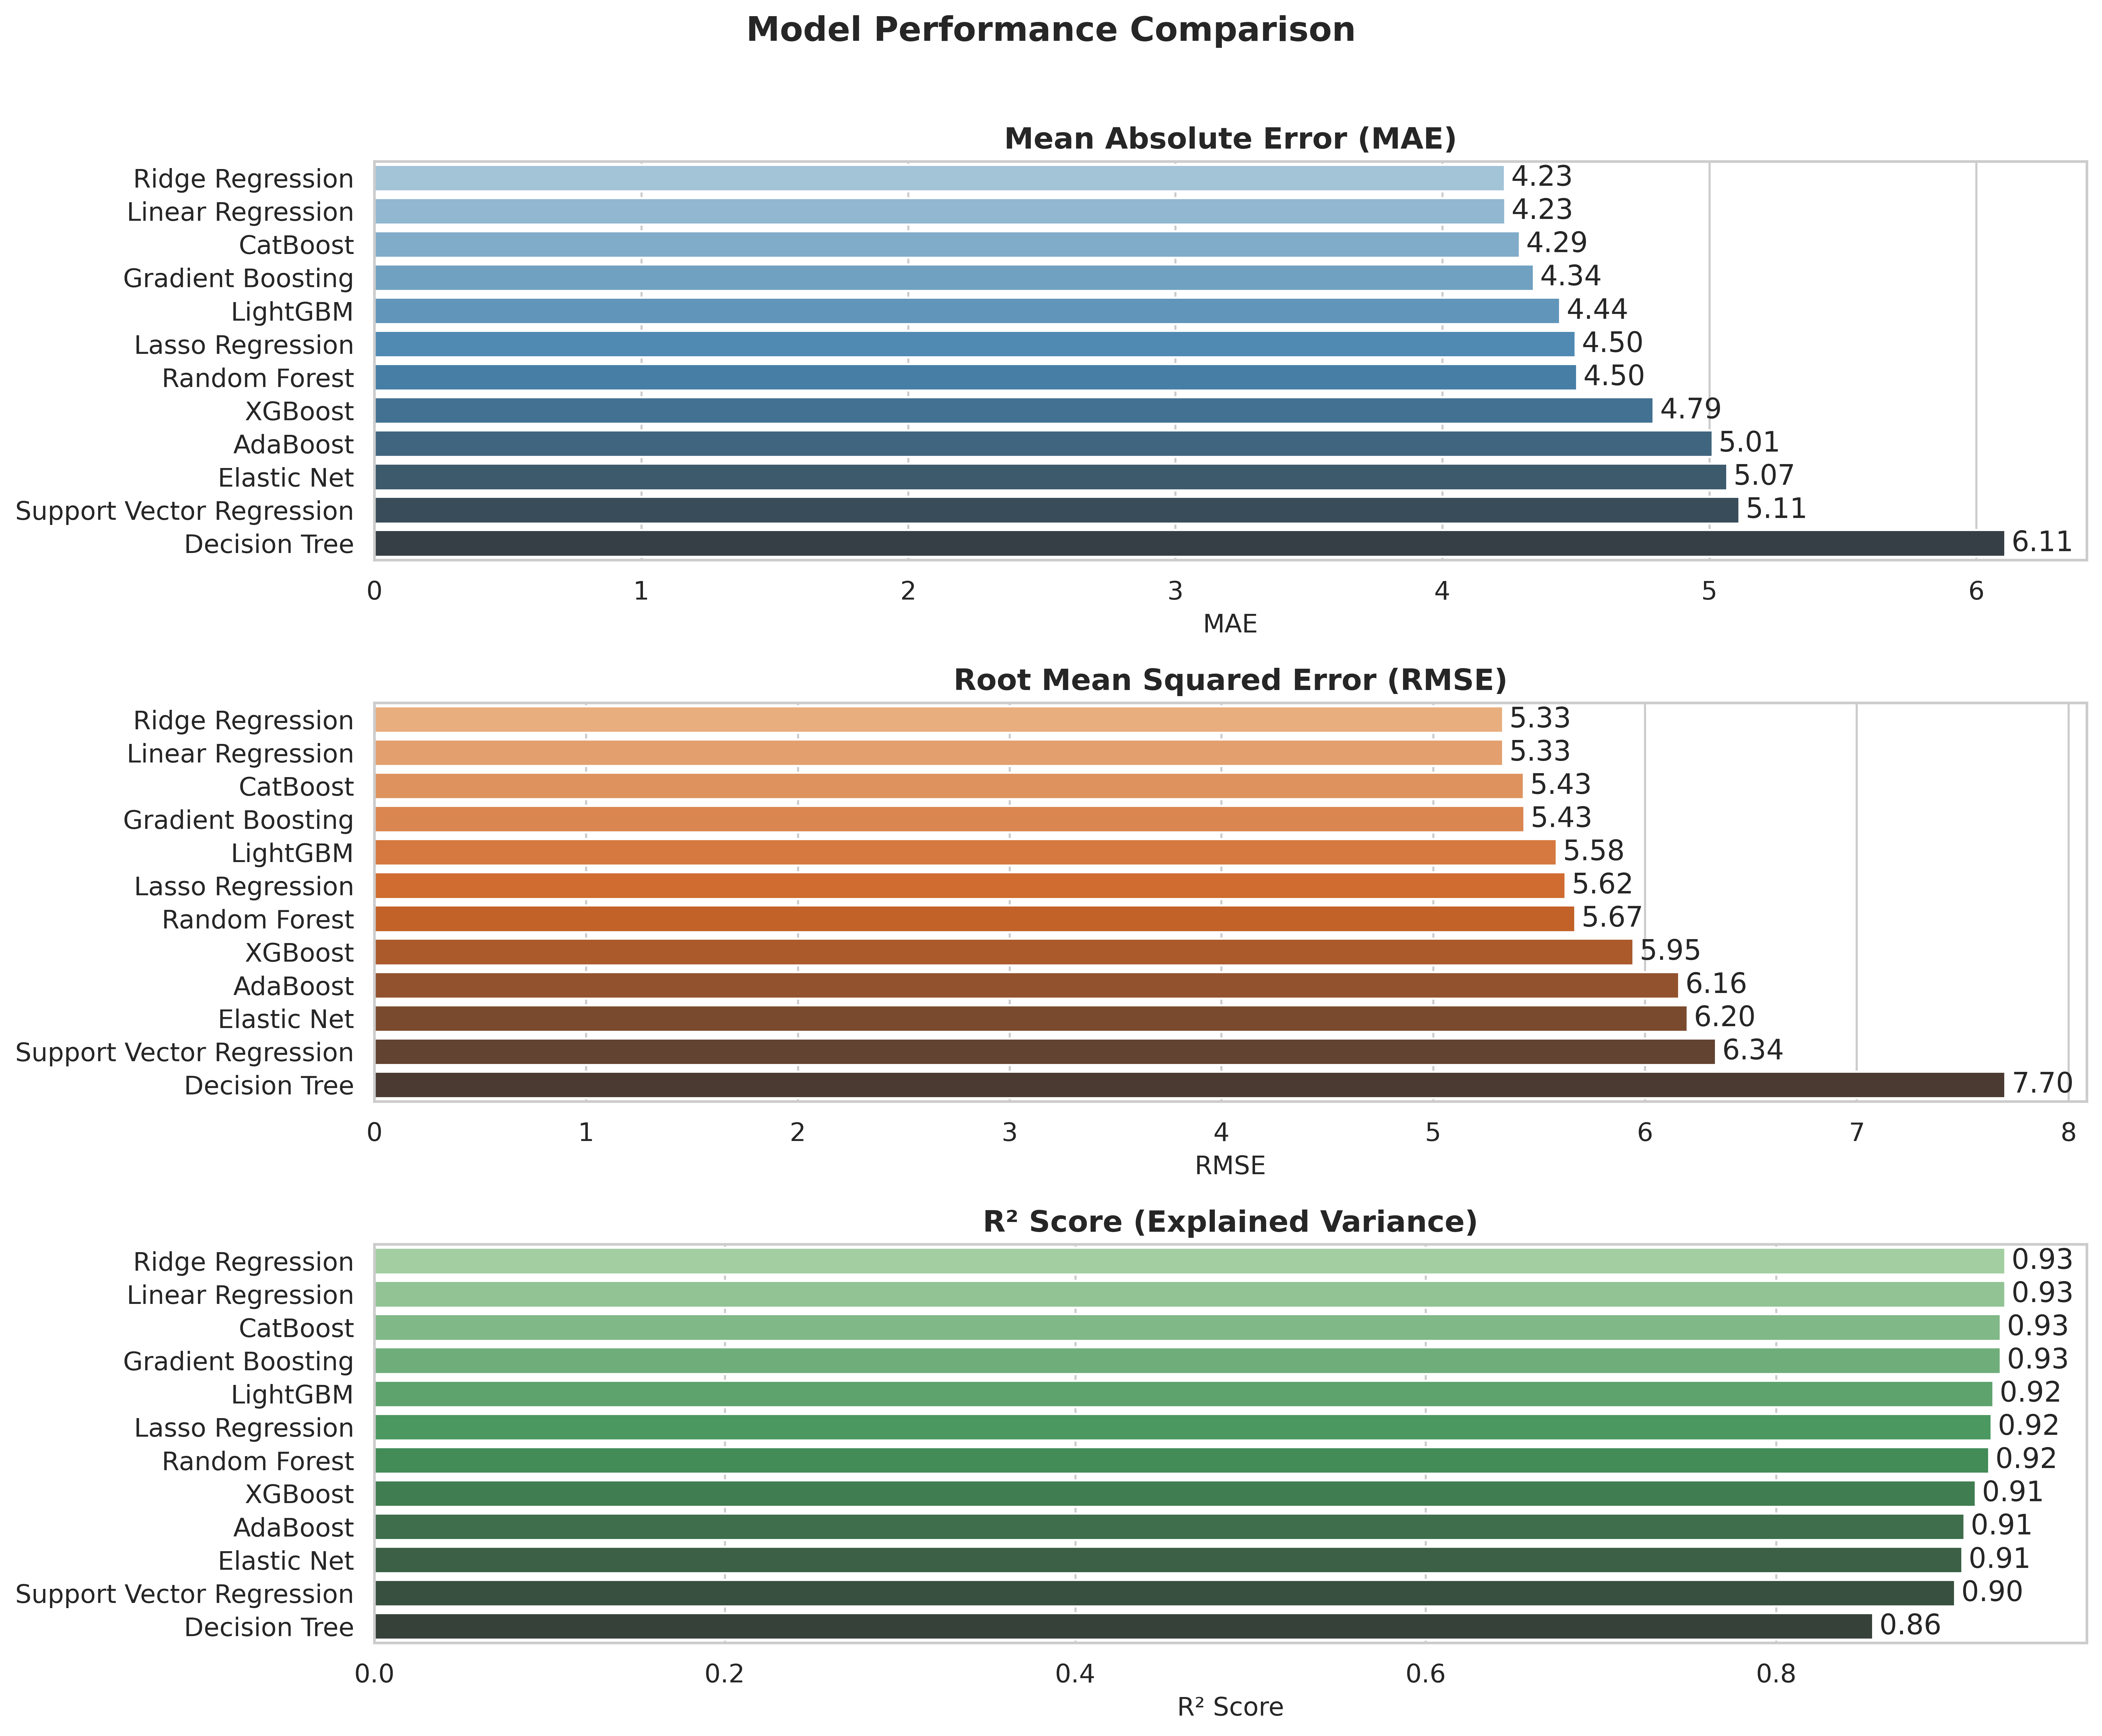

In [29]:
results_df_sorted = results_df.sort_values(by='RMSE')

# Set plot style
sns.set(style="whitegrid", context='notebook', font_scale=1.1)

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 12), dpi=500)

# Plot MAE
sns.barplot(x='MAE', y='Model', data=results_df_sorted, ax=axes[0], palette='Blues_d')
axes[0].set_title('Mean Absolute Error (MAE)', fontsize=14, weight='bold')
axes[0].set_xlabel('MAE', fontsize=12)
axes[0].set_ylabel('')
axes[0].bar_label(axes[0].containers[0], fmt='%.2f', label_type='edge', padding=3)

# Plot RMSE
sns.barplot(x='RMSE', y='Model', data=results_df_sorted, ax=axes[1], palette='Oranges_d')
axes[1].set_title('Root Mean Squared Error (RMSE)', fontsize=14, weight='bold')
axes[1].set_xlabel('RMSE', fontsize=12)
axes[1].set_ylabel('')
axes[1].bar_label(axes[1].containers[0], fmt='%.2f', label_type='edge', padding=3)

# Plot R² Score
sns.barplot(x='R² Score', y='Model', data=results_df_sorted, ax=axes[2], palette='Greens_d')
axes[2].set_title('R² Score (Explained Variance)', fontsize=14, weight='bold')
axes[2].set_xlabel('R² Score', fontsize=12)
axes[2].set_ylabel('')
axes[2].bar_label(axes[2].containers[0], fmt='%.2f', label_type='edge', padding=3)

# Overall layout adjustments
plt.suptitle("Model Performance Comparison", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

### Best Performing Models

- The dataset exhibits strong linear correlations, which linear models like Ridge and Linear Regression leverage effectively.
- Ridge adds regularization, improving generalization and numerical stability.
- Gradient Boosting and CatBoost effectively model non-linear interactions, benefiting from the cleaned, reduced-noise dataset.
- CatBoost also handles categorical features internally, reducing preprocessing complexity.


### Moderate Performing Models

- Tree-based models like LightGBM and Random Forest are naturally robust to outliers, so the impact of cleaning was marginal.
- Lasso’s L1 regularization may discard mildly informative features, which can slightly degrade performance.
- XGBoost and AdaBoost may require more hyperparameter tuning to compete with well-regularized linear or gradient-based models.


### Lower Performing Models

- SVR is highly sensitive to feature scale and kernel choice; without kernel tuning and proper scaling adjustments, it may not generalize well.
- Elastic Net, which combines L1 and L2 penalties, might struggle when there is multicollinearity or when relevant features are penalized too heavily.
- Decision Tree performed the worst, possibly due to its tendency to create complex splits that do not generalize. While overfitting is a factor, its greedy nature and lack of ensemble smoothing also contribute.


### Final Recommendations

- **Ridge Regression** and **Linear Regression** are the most reliable choices for this task, balancing accuracy, generalization, and robustness.
- **CatBoost** is also a strong candidate, especially for automated workflows involving categorical data.
- **Avoid using standalone Decision Trees or under-tuned SVR/ElasticNet models**, as their performance is inconsistent across evaluation metrics.

This analysis demonstrates that **preprocessing and data cleaning (especially outlier handling)** can have a meaningful impact — particularly on models that rely on distribution assumptions or are sensitive to data variance.


## 12. Deep Neural Network (DNN) Modeling

We design and train a baseline deep neural network using Keras:

* **Architecture**: Dense layers with ReLU activation, Dropout for regularization.
* **Optimizer**: Adam with a learning rate of 0.001.
* **Loss Function**: Mean Squared Error (MSE), suitable for regression tasks.
* **Metrics**: Mean Absolute Error (MAE) is tracked for performance.
* **Validation**: A portion of the training data is used to monitor generalization.

The model's training history is visualized to analyze learning progression and possible overfitting.

In [30]:
X_train_scaled_data = X_scaled_data
X_val_scaled_data = X_val_scaled
y_train_data = y_train_clean
y_val_data = y_val

# Define model configurations to experiment with
dnn_configs = [
    {"name": "Baseline", "layers": [128, 64, 32], "dropout": 0.2, "optimizer": Adam(0.001), "batch_norm": False},
    {"name": "Deep_Regularized", "layers": [256, 128, 64], "dropout": 0.3, "optimizer": Adam(0.001), "batch_norm": False},
    {"name": "BatchNorm_Model", "layers": [128, 64, 32], "dropout": 0.2, "optimizer": Adam(0.001), "batch_norm": True},
    {"name": "RMSProp_Model", "layers": [128, 64], "dropout": 0.2, "optimizer": RMSprop(0.001), "batch_norm": False},
    {"name": "Smaller_LR", "layers": [128, 64, 32], "dropout": 0.2, "optimizer": Adam(0.0005), "batch_norm": False}
]

# Function to build and train model
def run_dnn_experiment(config):
    model = Sequential()
    for i, units in enumerate(config['layers']):
        model.add(Dense(units, activation='relu', input_shape=(X_train_scaled_data.shape[1],) if i == 0 else None))
        if config['batch_norm']:
            model.add(BatchNormalization())
        model.add(Dropout(config['dropout']))
    model.add(Dense(1))

    model.compile(optimizer=config['optimizer'], loss='mse', metrics=['mae'])
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(X_train_scaled_data, y_train_data,
              validation_data=(X_val_scaled_data, y_val_data),
              epochs=100, batch_size=32, verbose=0,
              callbacks=[early_stop])

    preds = model.predict(X_val_scaled_data).flatten()
    mae = mean_absolute_error(y_val_data, preds)
    rmse = np.sqrt(mean_squared_error(y_val_data, preds))
    r2 = r2_score(y_val_data, preds)

    return {
        "Model": config['name'],
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2),
        "R² Score": round(r2, 3)
    }

# Run all experiments and collect results
dnn_results = [run_dnn_experiment(cfg) for cfg in dnn_configs]

# Convert to DataFrame for display
dnn_results_df = pd.DataFrame(dnn_results).sort_values(by="RMSE")
dnn_results_df

2025-05-15 08:47:00.274759: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Model   MAE  RMSE  R² Score
3     RMSProp_Model  4.17  5.27     0.932
4        Smaller_LR  4.15  5.30     0.932
0          Baseline  4.28  5.39     0.929
1  Deep_Regularized  4.26  5.41     0.929
2   BatchNorm_Model  4.32  5.50     0.926

## 13. Final Model Selection and Deployment

Based on the final evaluation **RMSProp DNN** outperformed Ridge Regression across all major metrics.

I chose to deploy the **best-performing model** based on:

- Superior prediction metrics (lower MAE and RMSE, higher R²)
- Sufficient generalization as shown on validation data
- Robustness after experimentation and tuning

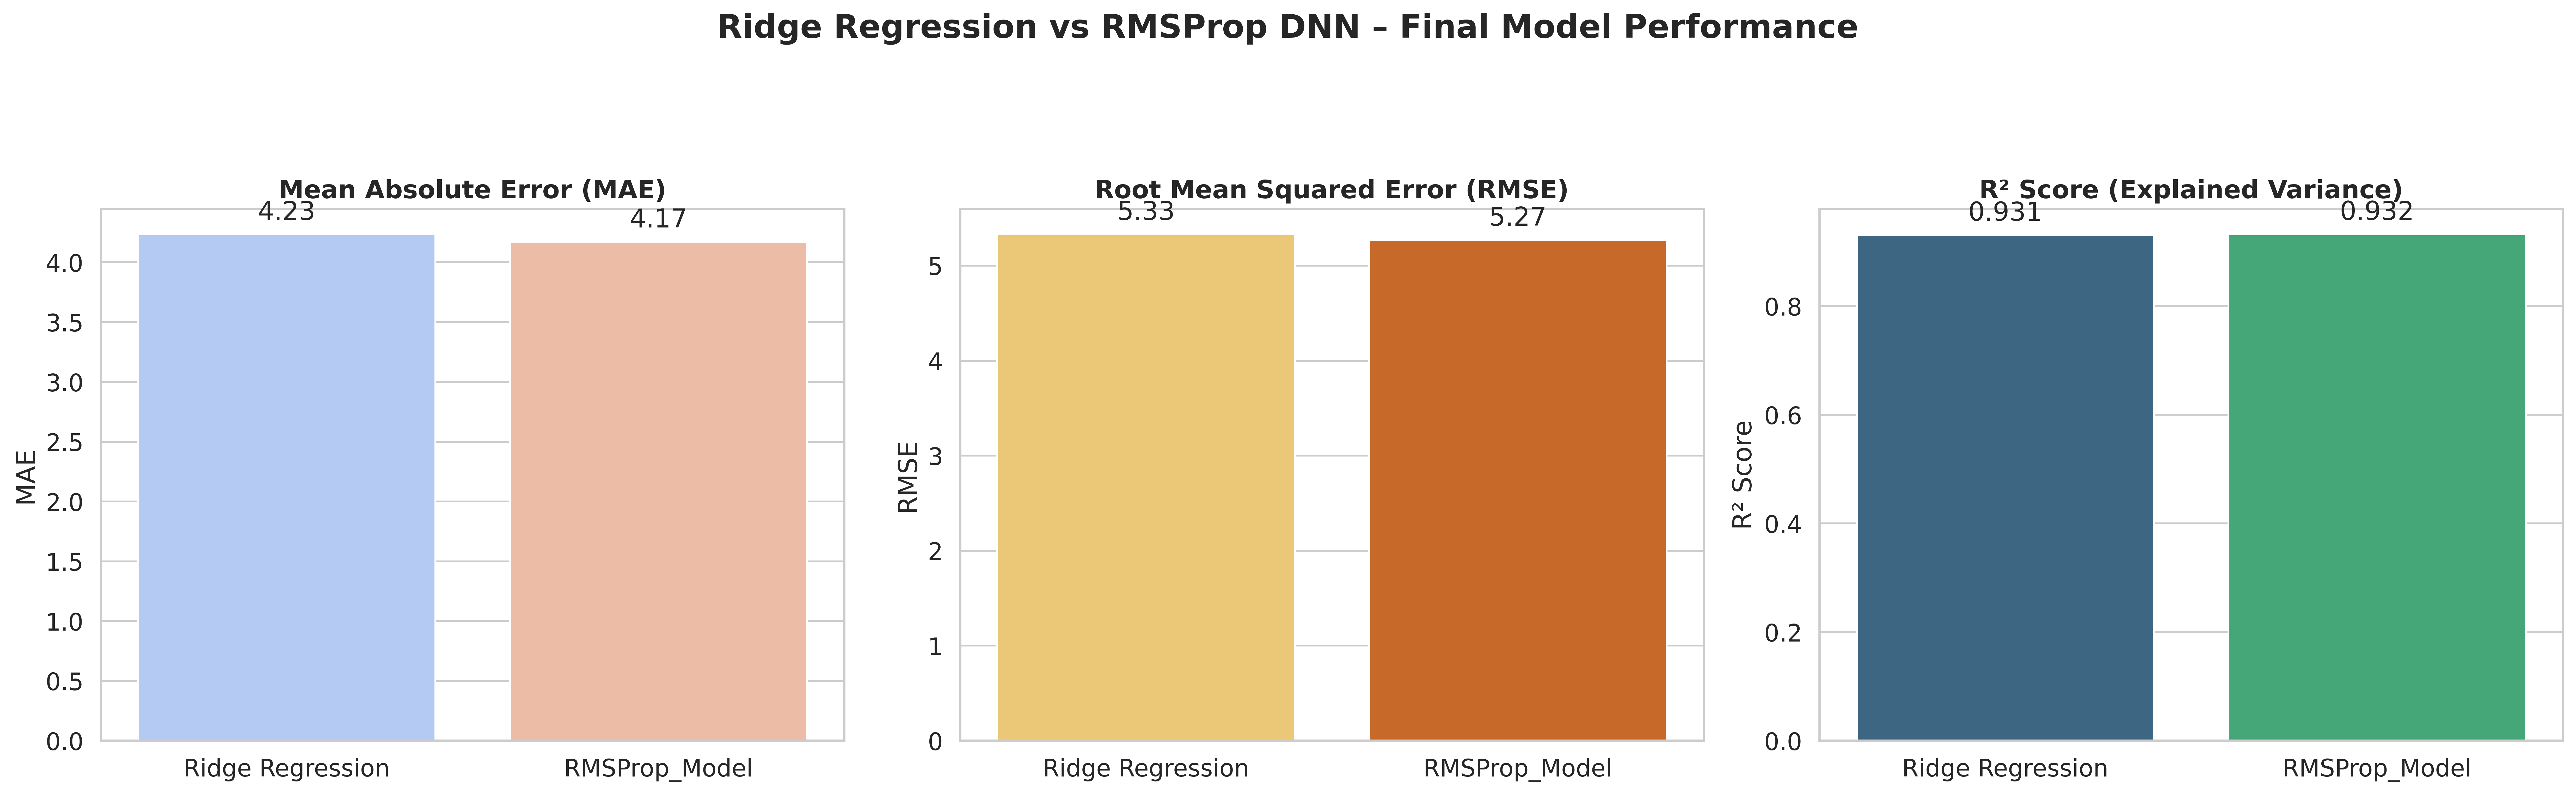

In [31]:
# Extract best-performing Ridge Regression result
ridge_row = results_df[results_df['Model'] == 'Ridge Regression'].iloc[0]

# Extract best-performing DNN (RMSProp) result
rmsprop_row = dnn_results_df[dnn_results_df['Model'] == 'RMSProp_Model'].iloc[0]

comparison_dynamic = pd.DataFrame({
    'Model': ['Ridge Regression', 'RMSProp_Model'],
    'MAE': [ridge_row['MAE'], rmsprop_row['MAE']],
    'RMSE': [ridge_row['RMSE'], rmsprop_row['RMSE']],
    'R² Score': [ridge_row['R² Score'], rmsprop_row['R² Score']]
})

sns.set(style="whitegrid", font_scale=1.2)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6), dpi=500)

# Custom palettes
palettes = [
    sns.color_palette("coolwarm", 2),
    sns.color_palette("YlOrBr", 2),
    sns.color_palette("viridis", 2)
]

metrics = ['MAE', 'RMSE', 'R² Score']
titles = [
    'Mean Absolute Error (MAE)',
    'Root Mean Squared Error (RMSE)',
    'R² Score (Explained Variance)'
]

# Iterate over metrics to create subplots
for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(x='Model', y=metric, data=comparison_dynamic, ax=ax, palette=palettes[i])
    ax.set_title(titles[i], fontsize=14, weight='bold')
    ax.set_xlabel('')
    ax.set_ylabel(metric)
    
    # Add value labels with spacing above the bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f' if metric == 'R² Score' else '%.2f',
                     label_type='edge', padding=5)

# Adjust layout and title
plt.suptitle("Ridge Regression vs RMSProp DNN – Final Model Performance", fontsize=18, weight='bold', y=1.05)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [32]:
# Save RMSProp DNN model

# Rebuild RMSProp model
model_rmsprop = Sequential([
    Dense(128, activation='relu', input_shape=(X_scaled_data.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Use explicit loss function object instead of string
model_rmsprop.compile(optimizer=RMSprop(0.001), loss=MeanSquaredError(), metrics=['mae'])

# Train the model
model_rmsprop.fit(X_scaled_data, y_train_clean,
                  validation_data=(X_val_scaled, y_val),
                  epochs=100,
                  batch_size=32,
                  verbose=0)

# Save model in a way that's safe to reload
model_rmsprop.save("rmsprop_dnn_best_model.h5")

## 14. Feature Importance

In [33]:
# Load the best DNN model
rmsprop_dnn_model = load_model("rmsprop_dnn_best_model.h5")

# Get predictions for baseline (unshuffled)
baseline_preds = rmsprop_dnn_model.predict(X_val_scaled).flatten()
baseline_mse = mean_squared_error(y_val, baseline_preds)

# Store importances
importances = {}

for i, col in enumerate(X_val_scaled.columns):
    X_temp = X_val_scaled.copy()
    X_temp[col] = np.random.permutation(X_temp[col])  # Shuffle one feature
    shuffled_preds = rmsprop_dnn_model.predict(X_temp).flatten()
    shuffled_mse = mean_squared_error(y_val, shuffled_preds)

    # Importance: How much the MSE increased
    importances[col] = shuffled_mse - baseline_mse

# Convert to DataFrame
importance_df = pd.DataFrame({
    "Feature": list(importances.keys()),
    "Importance": list(importances.values())
}).sort_values(by="Importance", ascending=False)

# Get top 10
top_10_features = importance_df.head(10)
top_10_features

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1

Feature  Importance
5           Bone Density (g/cm²)  191.292985
6               Vision Sharpness   78.248035
15         Smoking Status_Former    7.217267
14        Smoking Status_Current    7.038291
36       Sleep Patterns_Insomnia    6.603584
29  Family History_Heart Disease    6.254716
7           Hearing Ability (dB)    6.251635
27        Medication Use_Regular    6.157622
19                 Diet_Balanced    5.744497
26     Medication Use_Occasional    5.639924

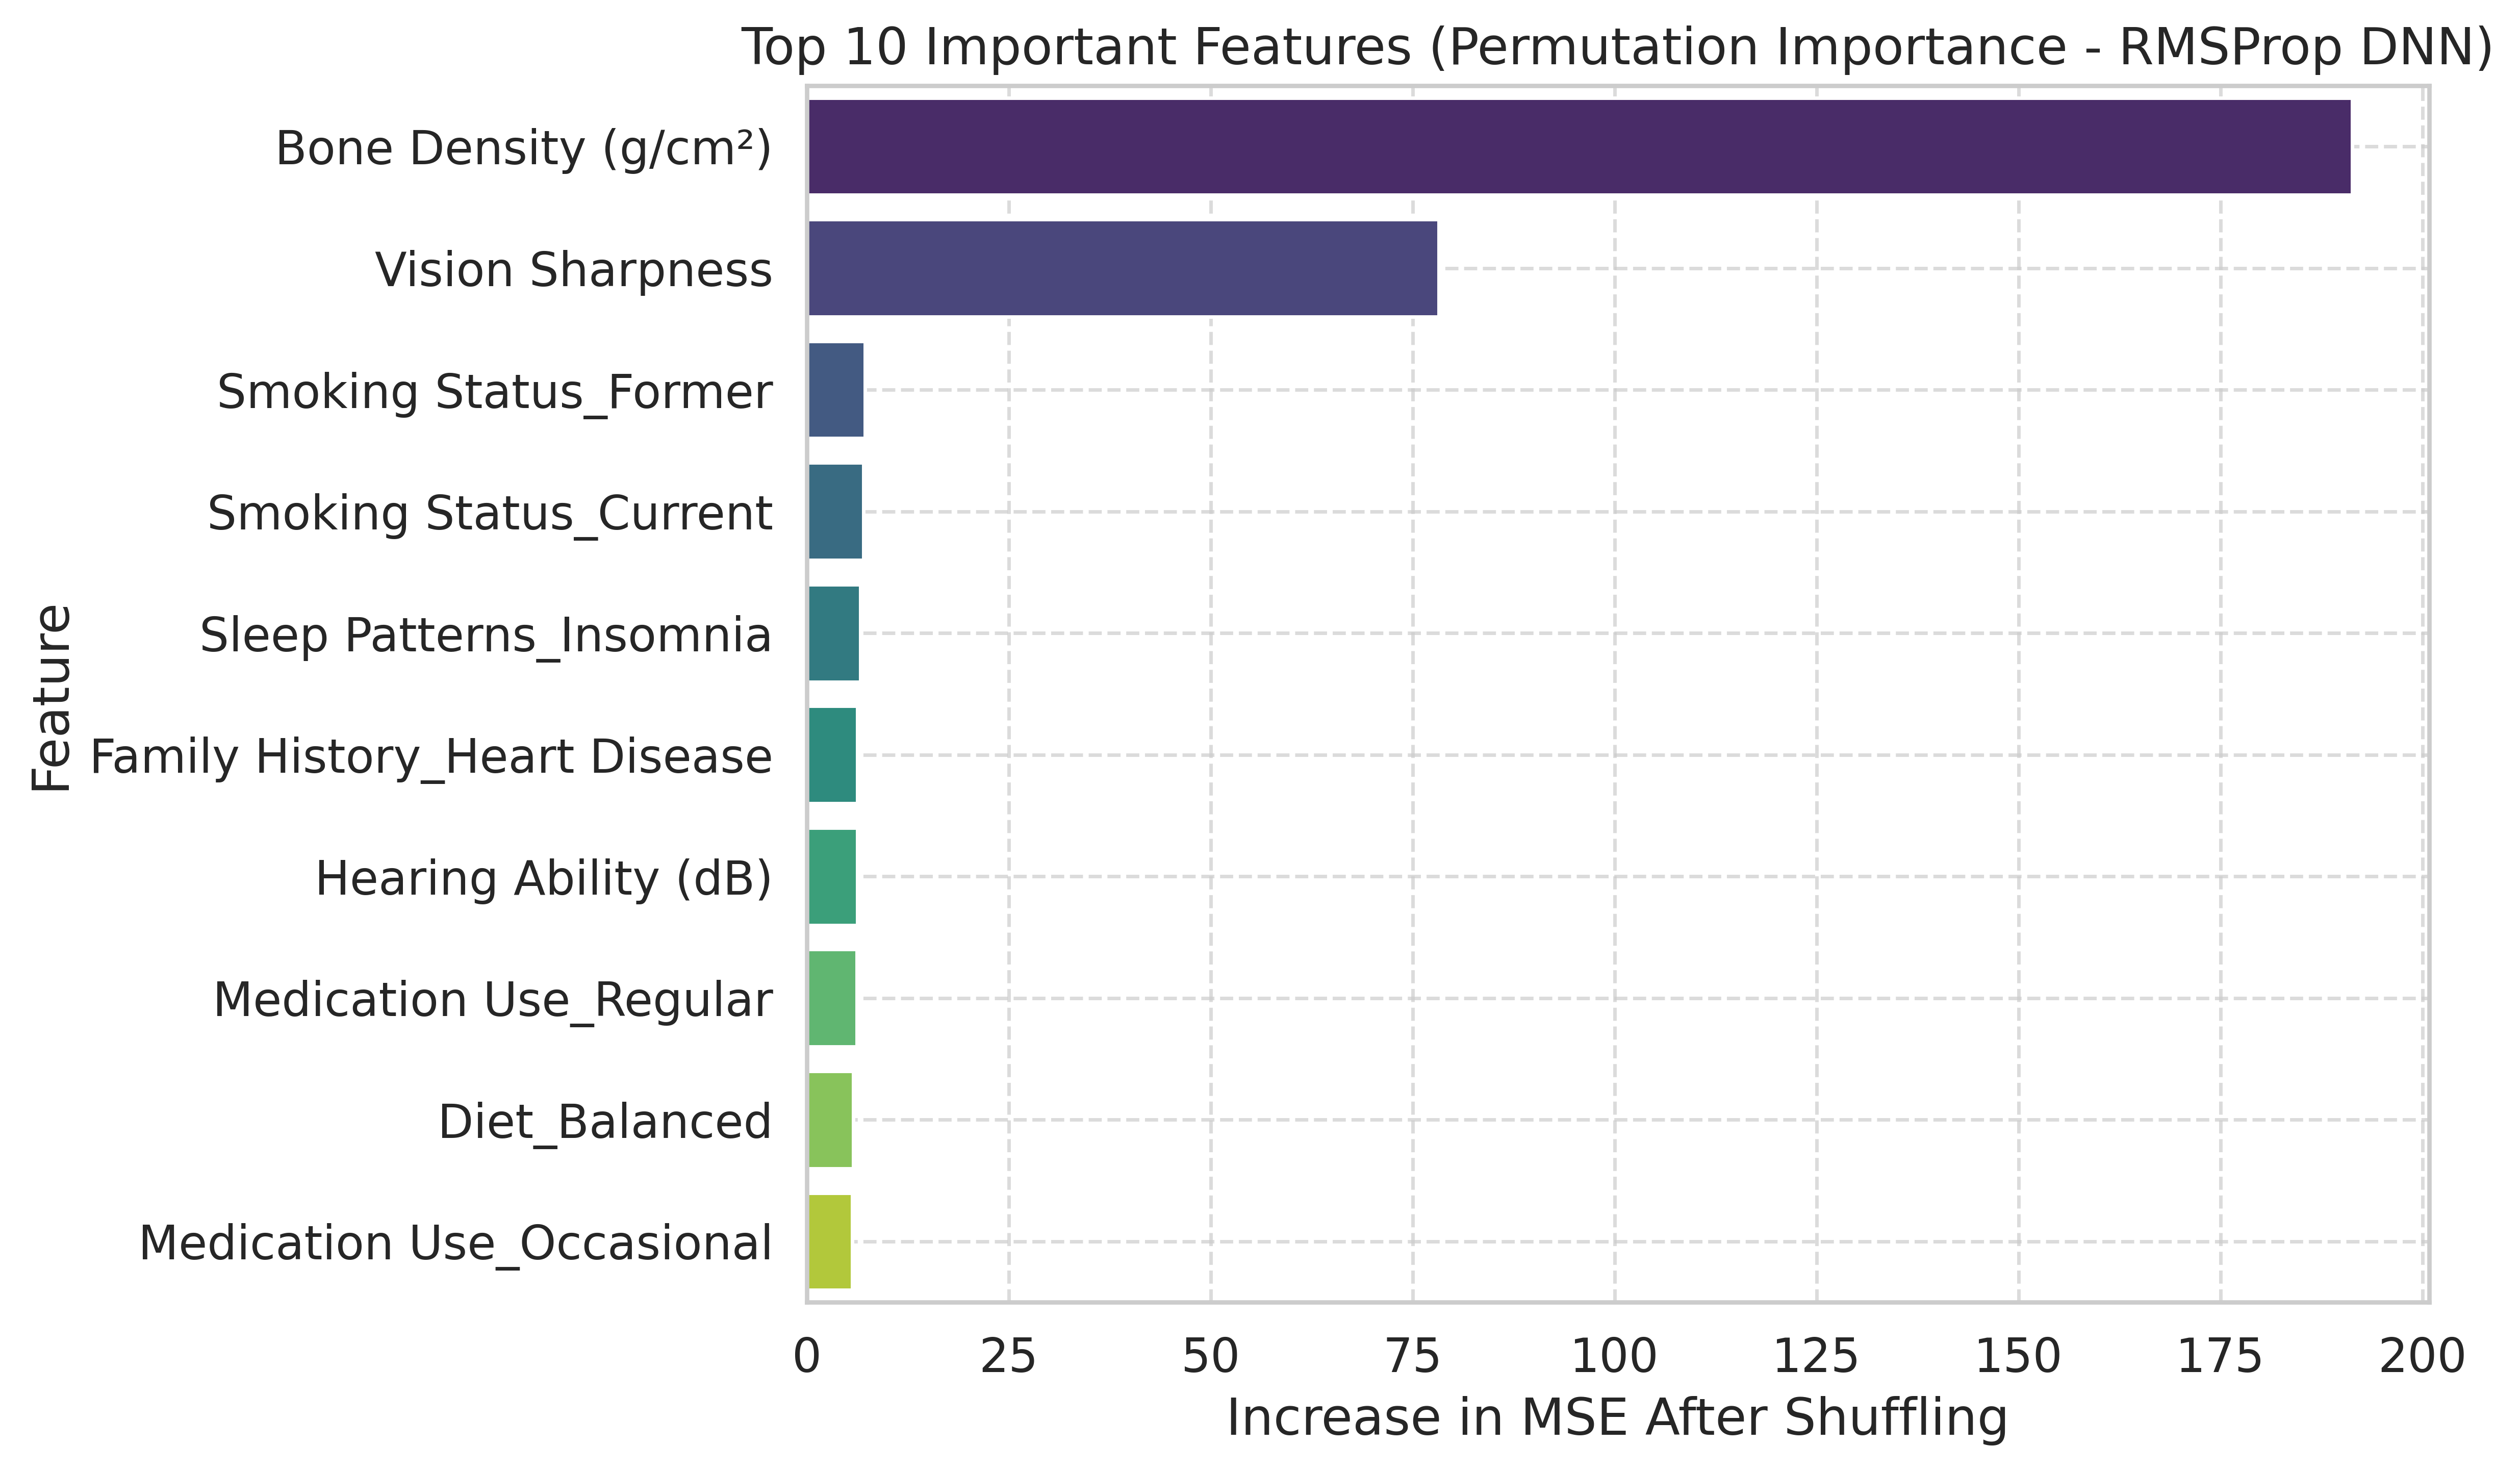

In [34]:
plt.figure(figsize=(10, 6), dpi=500)
sns.barplot(data=top_10_features, y='Feature', x='Importance', palette='viridis')
plt.title("Top 10 Important Features (Permutation Importance - RMSProp DNN)")
plt.xlabel("Increase in MSE After Shuffling")
plt.ylabel("Feature")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 15. Predict the target variable (Age) using RMSProp DNN model


In [35]:
# Load the model
rmsprop_dnn_model = load_model("rmsprop_dnn_best_model.h5")

# Preprocess test data
test_data = pd.read_csv('/kaggle/input/precision-health-predicting-human-age-with-biomark/Test.csv')
X_test_scaled = preprocess_and_transform_scaled(test_data)

# Predict
test_predictions = rmsprop_dnn_model.predict(X_test_scaled).flatten()
test_predictions = np.round(test_predictions).astype(int)

# Prepare submission
submission = pd.DataFrame({
    "ID": test_data["ID"],
    "Gender": test_data["Gender"],
    "Age(years)": test_predictions
})

# Save CSV
submission.to_csv("submission.csv", index=False)
submission

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


ID  Gender  Age(years)
0        1    Male          86
1        2    Male          72
2        3  Female          73
3        4  Female          50
4        5  Female          76
...    ...     ...         ...
2995  2996    Male          26
2996  2997    Male          19
2997  2998    Male          80
2998  2999  Female          31
2999  3000    Male          56

[3000 rows x 3 columns]


# Conclusion and Takeaways

- **DNNs can perform very well** on tabular data when appropriately tuned.
- While traditional models like Ridge Regression are faster and easier to interpret, **deep learning models can edge ahead** in performance for complex, non-linear relationships.
- The notion that **“neural networks are bad for tabular data” is outdated**—with enough care, they are strong contenders.

✅ **Best Overall Model (Deployed)**: **RMSProp DNN**